<a href="https://colab.research.google.com/github/alisonyang/data-science-blog/blob/main/NLP_Text_Embedding_Chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Binary Classifier Using Chinese-Language Movie Reviews

You will build a simple binary classification model to distinguish between positive and negative movie reviews, trained on the [豆瓣 movies short reviews](https://www.kaggle.com/datasets/utmhikari/doubanmovieshortcomments) dataset. The main goal of the project is to visualize embeddings produced by the model for Chinese language text using Tensorflow Embedding Projector.

## Download the Dataset

First, you will need to download the dataset. This data source comes from Kaggle, and to fetch Kaggle data, please refer to the following: ['Easiest way to download kaggle data in Google Colab'](https://www.kaggle.com/general/74235).

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alisonyang","key":"f300ef15195bc928e383e9695c862c90"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# ! kaggle datasets list
!kaggle datasets download -d utmhikari/doubanmovieshortcomments --force

 95% 136M/144M [00:01<00:00, 44.3MB/s]
100% 144M/144M [00:01<00:00, 76.0MB/s]


In [7]:
! mkdir comments

In [8]:
! unzip -o doubanmovieshortcomments.zip -d comments

Archive:  doubanmovieshortcomments.zip
  inflating: comments/DMSC.csv       


## Check the dataset

In [9]:
import pandas as pd

comments = pd.read_csv('/content/comments/DMSC.csv')
comments.head()

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


In [10]:
# the dataset information
comments.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125056 entries, 0 to 2125055
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   ID             int64 
 1   Movie_Name_EN  object
 2   Movie_Name_CN  object
 3   Crawl_Date     object
 4   Number         int64 
 5   Username       object
 6   Date           object
 7   Star           int64 
 8   Comment        object
 9   Like           int64 
dtypes: int64(4), object(6)
memory usage: 162.1+ MB


In [11]:
comments['Star'].describe()

count    2.125056e+06
mean     3.638320e+00
std      1.240807e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Star, dtype: float64

As shown in the output above, the dataset contains a total of **2,125,056** reviews. For this project, we will only select the **Star**  and **Comment** columns to train our mode

## Extracting Labels from the 'Star' Column

In this project, we will simply transform the star rating into two labels:

*   1-3 stars: negative label (**0**)
*   4-5 stars: positive label (**1**)


In [12]:
comments["Star"].head()

0    3
1    2
2    2
3    4
4    2
Name: Star, dtype: int64

In [13]:
import numpy as np
comments["Star"] = np.where(comments["Star"] > 3, 1, 0)
comments["Star"].head()

0    0
1    0
2    0
3    1
4    0
Name: Star, dtype: int64

In [14]:
labels = comments['Star']
labels.head()

0    0
1    0
2    0
3    1
4    0
Name: Star, dtype: int64

## Split the dataset

We will split the dataset into a training set and a testing set in a 7:3 ratio.

In [15]:
reviews = comments['Comment']
reviews.head()

0                                        连奥创都知道整容要去韩国。
1     非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...
2     2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...
3     《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...
4                                    虽然从头打到尾，但是真的很无聊啊。
Name: Comment, dtype: object

In [16]:
training_size = 1500000

# Split the sentences
training_reviews = reviews[0:training_size].tolist()
testing_reviews = reviews[training_size:].tolist()

# Split the labels
training_labels = labels[0:training_size].tolist()
testing_labels = labels[training_size:].tolist()

In [17]:
print("training set length:", len(training_reviews))
print("testing_labels set length:", len(testing_reviews))
print(type(training_labels))

training set length: 1500000
testing_labels set length: 625056
<class 'list'>


## Preprocessing the train and test sets

Now you can preprocess the text and labels so it can be consumed by the model. 

1.   we will use Jieba to segment this Chinese text data.
2.   we will create the vocabulary using the `Tokenizer` class and generate padded token sequences using the `pad_sequences` method.
3.   we need to convert the labels into a Numpy array to ensure a valid data type for `model.fit()`.

In [19]:
!pip install jieba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import jieba

# from ckiptagger import WS
def jieba_cut(text):
  result = jieba.lcut(text, cut_all = False)

  # For the stop word list, please refer to this link: https://github.com/goto456/stopwords/blob/master/cn_stopwords.txt.
  stopword = open("cn_stopwords.txt", "r", encoding='UTF-8').read()
  stopword_list = stopword.split("\n")

  seg_result = []

  for word in result:
    if word not in stopword_list:
      seg_result.append(word)

  return " ".join(seg_result)

In [22]:
# use Jieba to segment the training and testing sets

traning_set = []
for review  in training_reviews:
  traning_set.append(jieba_cut(review))

testing_set = []
for review  in testing_reviews:
  testing_set.append(jieba_cut(review))


In [23]:
traning_set[:3]

['  奥创 知道 整容 韩国',
 '  非常 失望 剧本 完全 敷衍了事 主线 剧情 没 突破 理解 人物 缺乏 动机 正邪 之间 妇联 内部 没什么 火花 团结 - 分裂 - 团结 三段式 老套 其实 利用 积攒 下来 形象 魅力 搞 出 意思 剧本 写得 非常 肤浅 平面 场面 调度 混乱 呆板 满屏 铁甲 审美疲劳 笑 点算 差强人意',
 '  2015 年度 失望 作品 面面俱到 实则 画蛇添足 主题深刻 实则 老调重弹 推陈出新 实则 俗不可耐 场面 high 实则 high 劲 不足 气 一集 趣味 全无 这集 笑 点 明显 刻意 心虚 全片 没有 片段 紧张 激动 太弱 奥创']

In [26]:
testing_set[:3]

['  想 变坏 终将 变得 更好', '  2015 年 月 ~   第十部', '  电影 没有 扭曲 小说 原著 当年 幻想 场景 成为 现实 很棒']

In [24]:
# set parameters
vocab_size = 10000
max_length = 64
embedding_dim = 16

# for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(traning_set)
word_index = tokenizer.word_index

# pad the training sequences
training_sequences = tokenizer.texts_to_sequences(traning_set)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_set)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# convert the labels into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

Now that the data has been preprocessed, we can move on to building our binary classification model.

In [28]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 16)            160000    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 166,157
Trainable params: 166,157
Non-trainable params: 0
_________________________________________________________________


## Train the Model

The next step is to train our model. However, since the primary objective of this Jupyter Notebook is to visualize the text embedding information using the TensorFlow Embedding Projector, we won't be dedicating a significant amount of effort to training the model.

In [29]:
num_epochs = 10

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
46875/46875 - 261s - loss: 0.4796 - accuracy: 0.7661 - val_loss: 0.4856 - val_accuracy: 0.7575 - 261s/epoch - 6ms/step
Epoch 2/10
46875/46875 - 245s - loss: 0.4586 - accuracy: 0.7792 - val_loss: 0.4755 - val_accuracy: 0.7657 - 245s/epoch - 5ms/step
Epoch 3/10
46875/46875 - 250s - loss: 0.4482 - accuracy: 0.7855 - val_loss: 0.4768 - val_accuracy: 0.7655 - 250s/epoch - 5ms/step
Epoch 4/10
46875/46875 - 248s - loss: 0.4394 - accuracy: 0.7907 - val_loss: 0.4803 - val_accuracy: 0.7657 - 248s/epoch - 5ms/step
Epoch 5/10
46875/46875 - 240s - loss: 0.4329 - accuracy: 0.7944 - val_loss: 0.4857 - val_accuracy: 0.7621 - 240s/epoch - 5ms/step
Epoch 6/10
46875/46875 - 250s - loss: 0.4281 - accuracy: 0.7974 - val_loss: 0.4959 - val_accuracy: 0.7568 - 250s/epoch - 5ms/step
Epoch 7/10
46875/46875 - 245s - loss: 0.4243 - accuracy: 0.7997 - val_loss: 0.5111 - val_accuracy: 0.7469 - 245s/epoch - 5ms/step
Epoch 8/10
46875/46875 - 248s - loss: 0.4211 - accuracy: 0.8017 - val_loss: 0.5005 - val_a

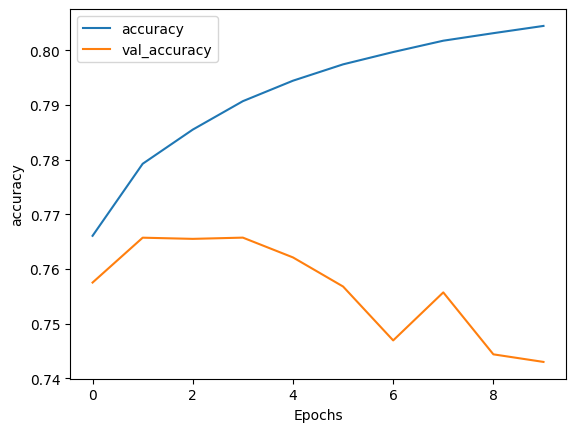

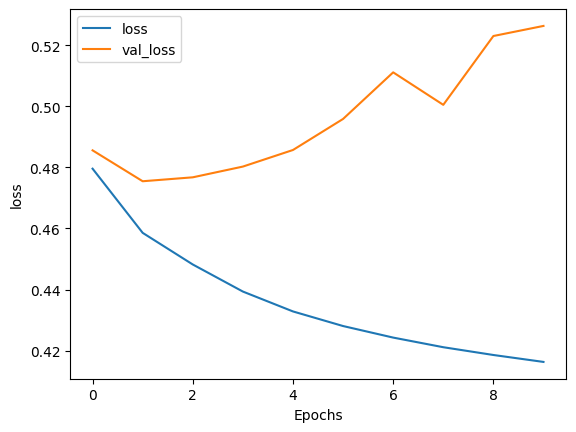

In [34]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Visualize Word Embeddings

After the model is trained, we can visualize the weights in the Embedding layer to observe how similar words are clustered together. To achieve this, we will use the [Tensorflow Embedding Projector](https://projector.tensorflow.org/)  to reduce the 16-dimensional vectors we defined earlier into fewer components that can be plotted in the projector. In order to obtain these weights, we can execute the cell below.

In [38]:
# use reverse_word_index to lookup a word 
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model
embedding_layer = model.layers[0]

# Get the weights 
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape) 


(10000, 16)


In [60]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word_name = reverse_word_index[word_num]
  word_embedding = embedding_weights[word_num]

  if len(word_name.strip()) != 0:
    # print(word_name)
    out_m.write(word_name + "\n")
    out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

out_v.close()
out_m.close()

In [61]:
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We can go to the [Tensorflow Embedding Projector](https://projector.tensorflow.org/) and load the two files:
* `vecs.tsv` - contains the vector weights of each word in the vocabulary
* `meta.tsv` - contains the words name in the vocabulary

You can try to search for words like `棒呆` and `大失所望` and see what other words are closely related to them. This could be a fun and engaging way to expand our vocabulary and explore the relationships between different words